In [1]:
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [4]:
# Dataframe
path_df = r"C:\ICE-1\ICE-1\03 Feature Engineering\Pickles\df.pickle"
with open(path_df, 'rb') as data:
    df = pickle.load(data)

# features_train
path_features_train = r"C:\ICE-1\ICE-1\03 Feature Engineering\Pickles\features_train.pickle"
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)

# labels_train
path_labels_train = r"C:\ICE-1\ICE-1\03 Feature Engineering\Pickles\labels_train.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)

# features_test
path_features_test = r"C:\ICE-1\ICE-1\03 Feature Engineering\Pickles\features_test.pickle"
with open(path_features_test, 'rb') as data:
    features_test = pickle.load(data)

# labels_test
path_labels_test = r"C:\ICE-1\ICE-1\03 Feature Engineering\Pickles\labels_test.pickle"
with open(path_labels_test, 'rb') as data:
    labels_test = pickle.load(data)

In [5]:
print(features_train.shape)
print(features_test.shape)

(926, 300)
(164, 300)


In [6]:
lr_0 = LogisticRegression(random_state = 8)

print('Parameters currently in use:\n')
pprint(lr_0.get_params())

Parameters currently in use:

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 8,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [7]:
# C
C = [float(x) for x in np.linspace(start = 0.1, stop = 1, num = 10)]

# multi_class
multi_class = ['multinomial']

# solver
solver = ['newton-cg', 'sag', 'saga', 'lbfgs']
 
# class_weight
class_weight = ['balanced', None]

# penalty
penalty = ['l2']

# Create the random grid
random_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

pprint(random_grid)

{'C': [0.1,
       0.2,
       0.30000000000000004,
       0.4,
       0.5,
       0.6,
       0.7000000000000001,
       0.8,
       0.9,
       1.0],
 'class_weight': ['balanced', None],
 'multi_class': ['multinomial'],
 'penalty': ['l2'],
 'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']}


In [8]:
# First create the base model to tune
lrc = LogisticRegression(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=lrc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

RandomizedSearchCV(cv=3, estimator=LogisticRegression(random_state=8),
                   n_iter=50,
                   param_distributions={'C': [0.1, 0.2, 0.30000000000000004,
                                              0.4, 0.5, 0.6, 0.7000000000000001,
                                              0.8, 0.9, 1.0],
                                        'class_weight': ['balanced', None],
                                        'multi_class': ['multinomial'],
                                        'penalty': ['l2'],
                                        'solver': ['newton-cg', 'sag', 'saga',
                                                   'lbfgs']},
                   random_state=8, scoring='accuracy', verbose=1)

In [9]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'solver': 'saga', 'penalty': 'l2', 'multi_class': 'multinomial', 'class_weight': 'balanced', 'C': 0.5}

The mean accuracy of a model with these hyperparameters is:
0.9557327785483126


In [10]:
# Create the parameter grid based on the results of random search 
C = [float(x) for x in np.linspace(start = 0.6, stop = 1, num = 10)]
multi_class = ['multinomial']
solver = ['sag']
class_weight = ['balanced']
penalty = ['l2']

param_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

# Create a base model
lrc = LogisticRegression(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=lrc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train, labels_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which mean

GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             estimator=LogisticRegression(random_state=8),
             param_grid={'C': [0.6, 0.6444444444444444, 0.6888888888888889,
                               0.7333333333333333, 0.7777777777777778,
                               0.8222222222222222, 0.8666666666666667,
                               0.9111111111111111, 0.9555555555555555, 1.0],
                         'class_weight': ['balanced'],
                         'multi_class': ['multinomial'], 'penalty': ['l2'],
                         'solver': ['sag']},
             scoring='accuracy', verbose=1)

In [11]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 0.6444444444444444, 'class_weight': 'balanced', 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag'}

The mean accuracy of a model with these hyperparameters is:
0.9629629629629629


In [12]:
best_lrc = grid_search.best_estimator_

In [13]:
best_lrc

LogisticRegression(C=0.6444444444444444, class_weight='balanced',
                   multi_class='multinomial', random_state=8, solver='sag')

In [14]:
best_lrc.fit(features_train, labels_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(C=0.6444444444444444, class_weight='balanced',
                   multi_class='multinomial', random_state=8, solver='sag')

In [15]:
lrc_pred = best_lrc.predict(features_test)

In [16]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train, best_lrc.predict(features_train)))

The training accuracy is: 
0.9773218142548596


In [17]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test, lrc_pred))

The test accuracy is: 
0.9573170731707317


In [18]:
# Classification report
print("Classification report")
print(classification_report(labels_test,lrc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.85      0.94      0.89        18
           1       0.96      1.00      0.98        74
           2       0.99      0.92      0.95        72

    accuracy                           0.96       164
   macro avg       0.93      0.95      0.94       164
weighted avg       0.96      0.96      0.96       164



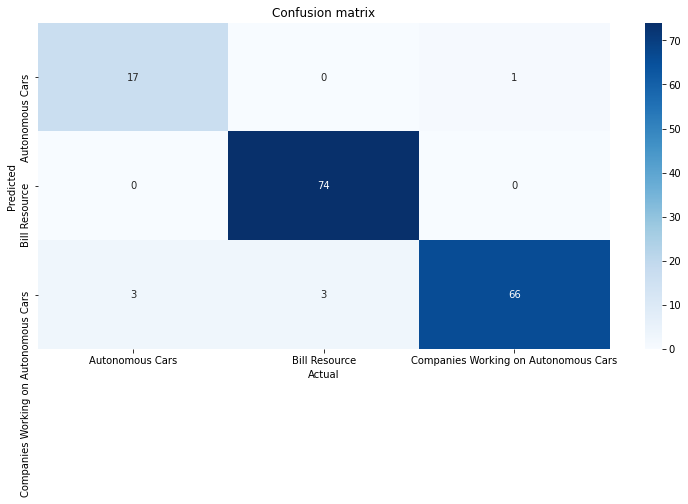

In [19]:
aux_df = df[['Category', 'Category_Code']].drop_duplicates().sort_values('Category_Code')
conf_matrix = confusion_matrix(labels_test, lrc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Category'].values, 
            yticklabels=aux_df['Category'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [20]:
base_model = LogisticRegression(random_state = 8)
base_model.fit(features_train, labels_train)
accuracy_score(labels_test, base_model.predict(features_test))

0.9390243902439024

In [21]:
best_lrc.fit(features_train, labels_train)
accuracy_score(labels_test, best_lrc.predict(features_test))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


0.9573170731707317

In [22]:
d = {
     'Model': 'Logistic Regression',
     'Training Set Accuracy': accuracy_score(labels_train, best_lrc.predict(features_train)),
     'Test Set Accuracy': accuracy_score(labels_test, lrc_pred)
}

df_models_lrc = pd.DataFrame(d, index=[0])

In [23]:
df_models_lrc

,Model,Training Set Accuracy,Test Set Accuracy
0,Logistic Regression,0.977322,0.957317


In [25]:
with open('best_lrc.pickle', 'wb') as output:
    pickle.dump(best_lrc, output)
    
with open('df_models_lrc.pickle', 'wb') as output:
    pickle.dump(df_models_lrc, output)